# Análise das informações de limpeza de dados Viagens_2025

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from matplotlib.ticker import ScalarFormatter


In [33]:
engine = create_engine(
    "postgresql://bi_bancos2:1q2w3e@db:5432/viagens_db"
)

In [36]:
df = pd.read_sql("SELECT * FROM viagem", engine)
df.head()
df.columns


Index(['ide_pro_via', 'nmr_ppt_pcd', 'situacao', 'via_urg', 'jus_urg_via',
       'cod_org_sup', 'nom_org_sup', 'cod_org_sol', 'nom_org_sol', 'cpf_vjt',
       'nome', 'cargo', 'funcao', 'dat_ini', 'dat_fim', 'destinos', 'motivo',
       'val_dia', 'val_pas', 'val_dev', 'val_out_gas', 'tot_gas', 'mes_ida',
       'mes_vol'],
      dtype='str')

Após a ingestão dos dados brutos (Raw), foi realizada a etapa de tratamento e padronização dos dados, originando a camada Silver. Nessa fase, os dados passaram por processos de limpeza, filtragem e normalização, com o objetivo de garantir consistência, confiabilidade e aderência ao escopo analítico do projeto. Entre as principais intervenções realizadas destacam-se:
- Remoção de registros com datas inválidas ou inconsistentes
- Exclusão de viagens com valores financeiros nulos ou negativos
- Padronização de campos categóricos (destinos, funções e órgãos)
- Manutenção apenas de viagens efetivamente realizadas, descartando registros cancelados ou incompletos  
Essas ações impactam diretamente os resultados analíticos, tornando-os mais representativos da realidade operacional.

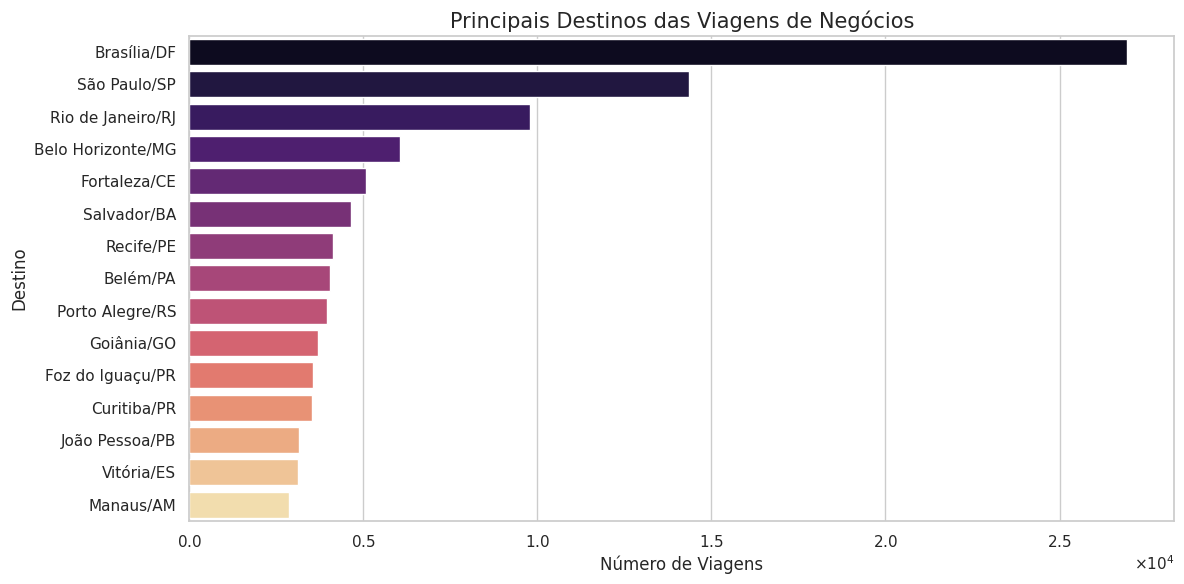

In [38]:
top_destinos = (
    df['destinos']
    .value_counts()
    .head(15)
    .reset_index()
)

top_destinos.columns = ['Cidade/UF', 'Qtd_Viagens']

ax = sns.barplot(
    data=top_destinos,
    x='Qtd_Viagens',
    y='Cidade/UF',
    hue='Cidade/UF',
    palette='magma',
    legend=False
)

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
ax.xaxis.set_major_formatter(formatter)

plt.title('Principais Destinos das Viagens de Negócios', fontsize=15)
plt.xlabel('Número de Viagens', fontsize=12)
plt.ylabel('Destino', fontsize=12)
plt.tight_layout()
plt.show()


A análise dos destinos evidencia que Brasília (DF), São Paulo (SP) e Rio de Janeiro (RJ) lideram o volume de viagens.
Esse comportamento é justificado por fatores estruturais:  
**Brasília** concentra a maior parte dos órgãos da administração pública federal, sendo o principal polo decisório e administrativo do país. **São Paulo** e **Rio de Janeiro** possuem elevada relevância econômica, institucional e logística, abrigando sedes regionais, autarquias, empresas públicas e eventos governamentais de grande porte.  
Após a filtragem dos dados na camada Silver, observou-se uma redução de destinos atípicos ou inconsistentes, o que reforça a concentração natural das viagens em capitais estratégicas e elimina distorções presentes na base bruta.

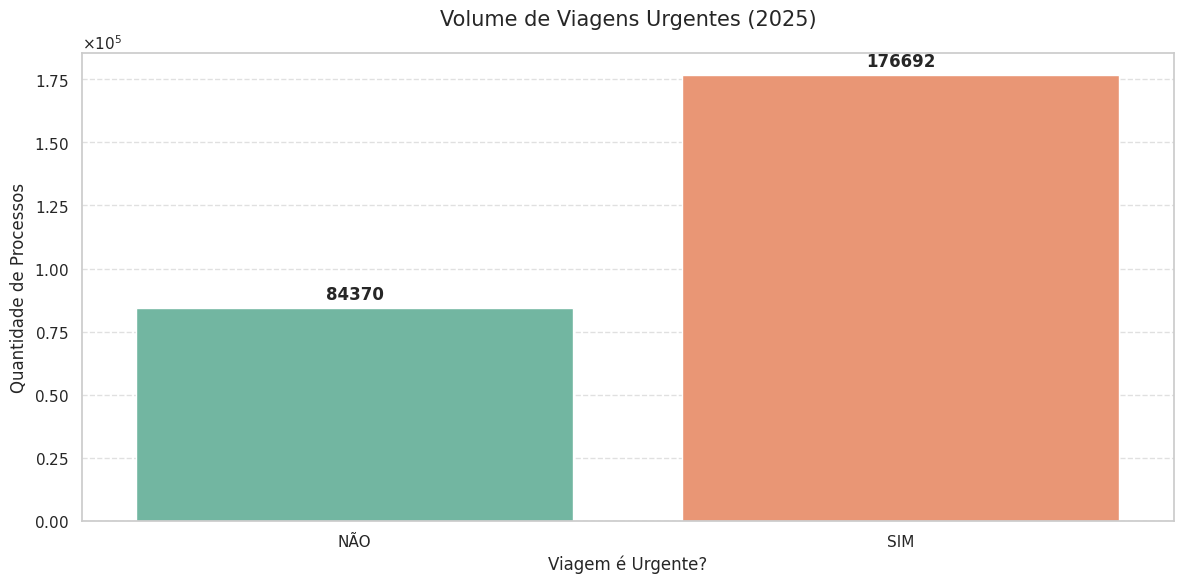

In [39]:
ax = sns.countplot(
    data=df,
    x='via_urg',
    hue='via_urg',
    palette='Set2',
    legend=False
)

for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontweight='bold',
        fontsize=12
    )

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
ax.yaxis.set_major_formatter(formatter)

plt.title('Volume de Viagens Urgentes (2025)', fontsize=15, pad=20)
plt.xlabel('Viagem é Urgente?', fontsize=12)
plt.ylabel('Quantidade de Processos', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Os dados tratados demonstram que a maioria das viagens possui caráter urgente.  
Esse resultado reflete: Demandas operacionais emergenciais; Atividades de fiscalização, auditoria, inspeção e gestão de crises; A natureza reativa de parte significativa das ações governamentais.  
Na camada Raw, existiam registros com marcação de urgência inconsistente ou ausente. Com a filtragem aplicada na Silver, apenas viagens com classificação válida de urgência foram consideradas, tornando o indicador mais confiável e revelando um padrão operacional realista.

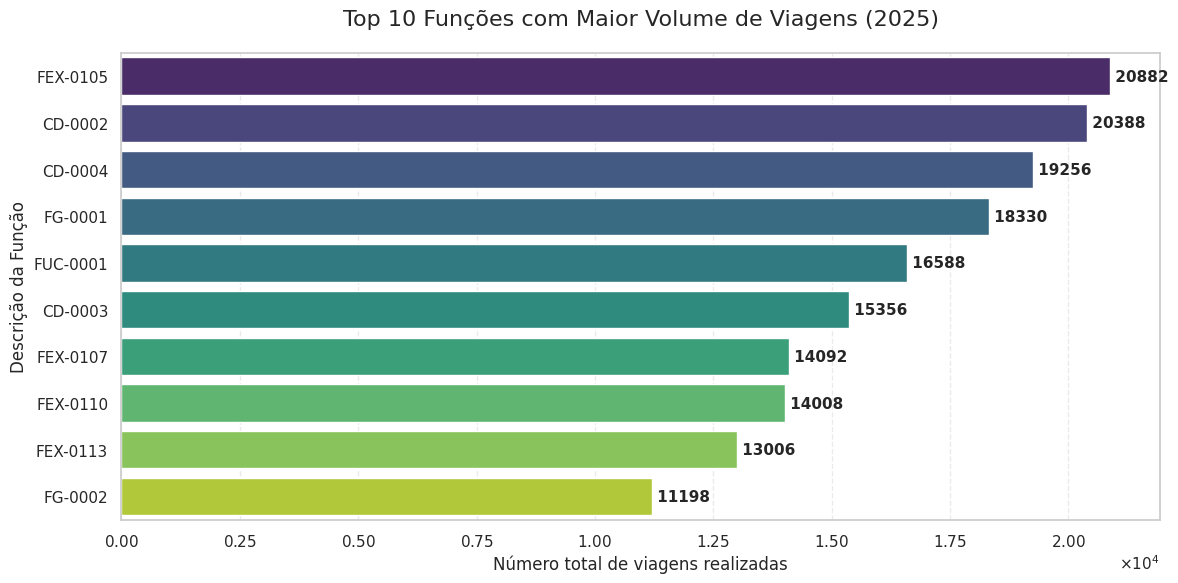

In [40]:
top_funcoes = (
    df['funcao']
    .value_counts()
    .head(10)
    .reset_index()
)

top_funcoes.columns = ['Função', 'Quantidade']

ax = sns.barplot(
    data=top_funcoes,
    x='Quantidade',
    y='Função',
    hue='Função',
    palette='viridis',
    legend=False
)

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
ax.xaxis.set_major_formatter(formatter)

for index, value in enumerate(top_funcoes['Quantidade']):
    plt.text(
        value,
        index,
        f' {int(value)}',
        va='center',
        fontsize=11,
        fontweight='bold'
    )

plt.title('Top 10 Funções com Maior Volume de Viagens (2025)', fontsize=16, pad=20)
plt.xlabel('Número total de viagens realizadas', fontsize=12)
plt.ylabel('Descrição da Função', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


As funções com maior concentração de viagens são:
- FEX0105
- CD0002
- CD0004
Essas funções estão associadas, em geral, a cargos técnicos, de coordenação ou de execução operacional, que demandam deslocamentos frequentes para: Supervisão de atividades descentralizadas; Acompanhamento de projetos; Articulação entre unidades administrativas.  
A filtragem da camada Silver eliminou registros onde a função estava ausente, inválida ou representada por códigos genéricos, garantindo que os volumes apresentados reflitam apenas funções efetivamente informadas e válidas.

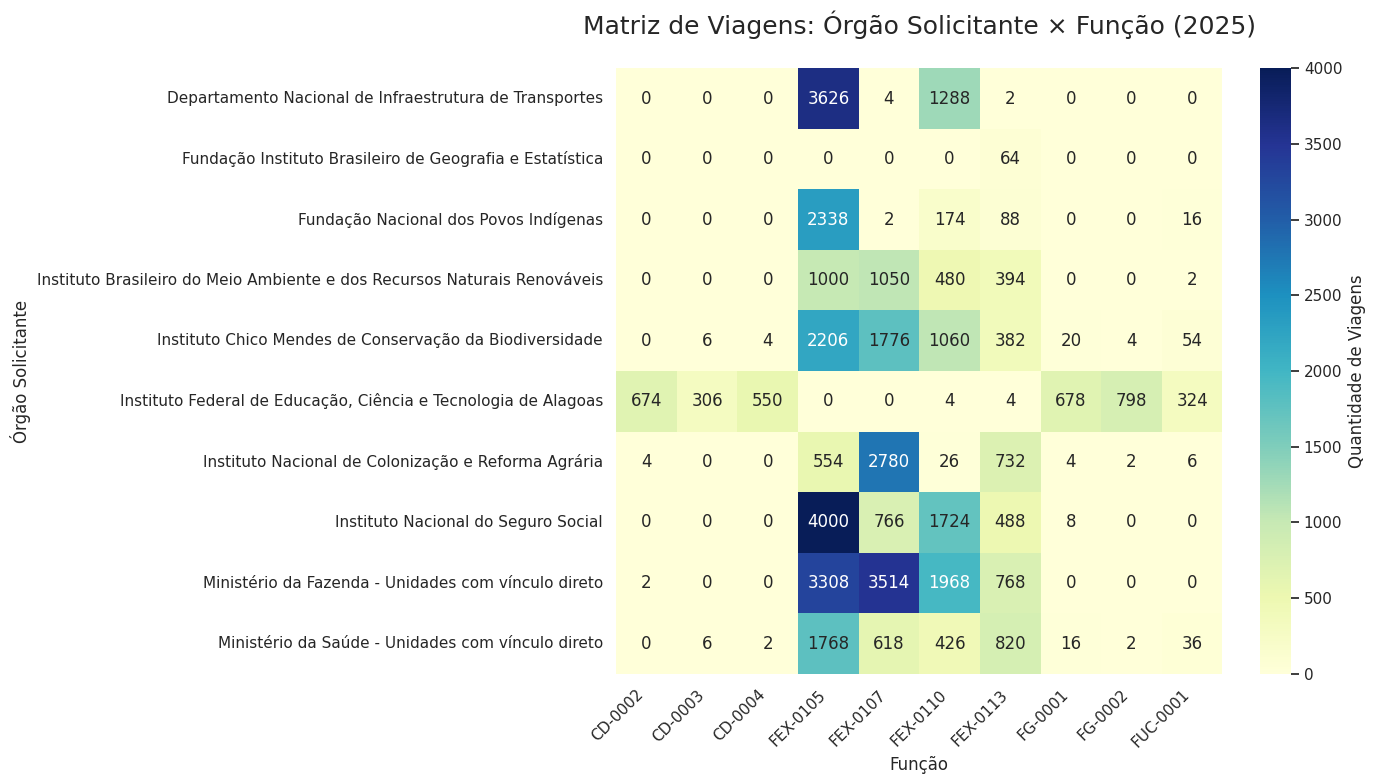

In [41]:
top_orgaos = df['nom_org_sol'].value_counts().nlargest(10).index
top_funcoes = df['funcao'].value_counts().nlargest(10).index

df_cruzado = df[
    df['nom_org_sol'].isin(top_orgaos) &
    df['funcao'].isin(top_funcoes)
]

matriz_viagens = (
    df_cruzado
    .groupby(['nom_org_sol', 'funcao'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(14, 8))
sns.heatmap(
    matriz_viagens,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    cbar_kws={'label': 'Quantidade de Viagens'}
)

plt.title('Matriz de Viagens: Órgão Solicitante × Função (2025)', fontsize=18, pad=25)
plt.xlabel('Função', fontsize=12)
plt.ylabel('Órgão Solicitante', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


A matriz cruzada evidencia que: O **Instituto Nacional do Seguro Social (INSS)** apresenta alta concentração de viagens associadas à função FEX0105; O **Departamento Nacional de Infraestrutura de Transportes (DNIT)** também se destaca, igualmente com predominância da função FEX0105;  
Esse resultado é coerente com o perfil operacional desses órgãos: O INSS possui ampla capilaridade nacional, demandando deslocamentos frequentes para gestão, auditoria e suporte técnico em agências distribuídas pelo território. O DNIT atua diretamente na fiscalização, manutenção e acompanhamento de obras de infraestrutura, atividades que exigem presença física em diferentes localidades.  
Após a filtragem aplicada na Silver, foram removidos órgãos com registros esporádicos ou inconsistentes, o que permitiu evidenciar com maior clareza a relação estrutural entre órgãos operacionais e funções técnicas, sem interferência de ruídos presentes na base bruta.

RELATÓRIO – FUNÇÃO = -1
Total de registros-----------------------: 261,062
Função = -1 (Não Informada)--------------: 0
Outras funções---------------------------: 261,062


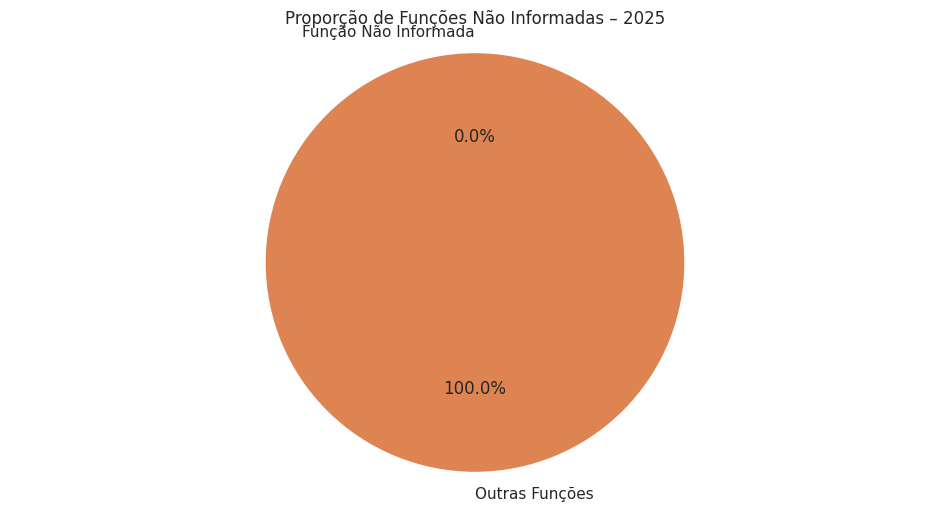

In [42]:
funcao = df['funcao']

total_linhas = len(df)
qtd_funcao_menos_um = (funcao == '-1').sum()
qtd_outras_funcoes = total_linhas - qtd_funcao_menos_um

print("RELATÓRIO – FUNÇÃO = -1")
print(f"Total de registros-----------------------: {total_linhas:,}")
print(f"Função = -1 (Não Informada)--------------: {qtd_funcao_menos_um:,}")
print(f"Outras funções---------------------------: {qtd_outras_funcoes:,}")

labels = ['Função Não Informada', 'Outras Funções']
sizes = [qtd_funcao_menos_um, qtd_outras_funcoes]

plt.figure()
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Proporção de Funções Não Informadas – 2025')
plt.axis('equal')
plt.show()


Após o processo de tratamento dos dados, todas as funções passaram a estar devidamente informadas. Registros que continham valores inválidos, genéricos ou indicadores de ausência de informação (como -1 ou equivalentes) foram integralmente removidos da base Silver.
Esse resultado evidencia: A melhoria significativa da qualidade dos dados; A eliminação de ruídos analíticos que comprometiam interpretações anteriores; A garantia de que todas as análises subsequentes sobre funções refletem informação confiável e completa.  
Diferentemente da camada Raw, onde uma parcela relevante dos registros possuía função não informada, a camada Silver assegura que 100% das viagens analisadas possuem **função válida**, reforçando a consistência do modelo analítico adotado.

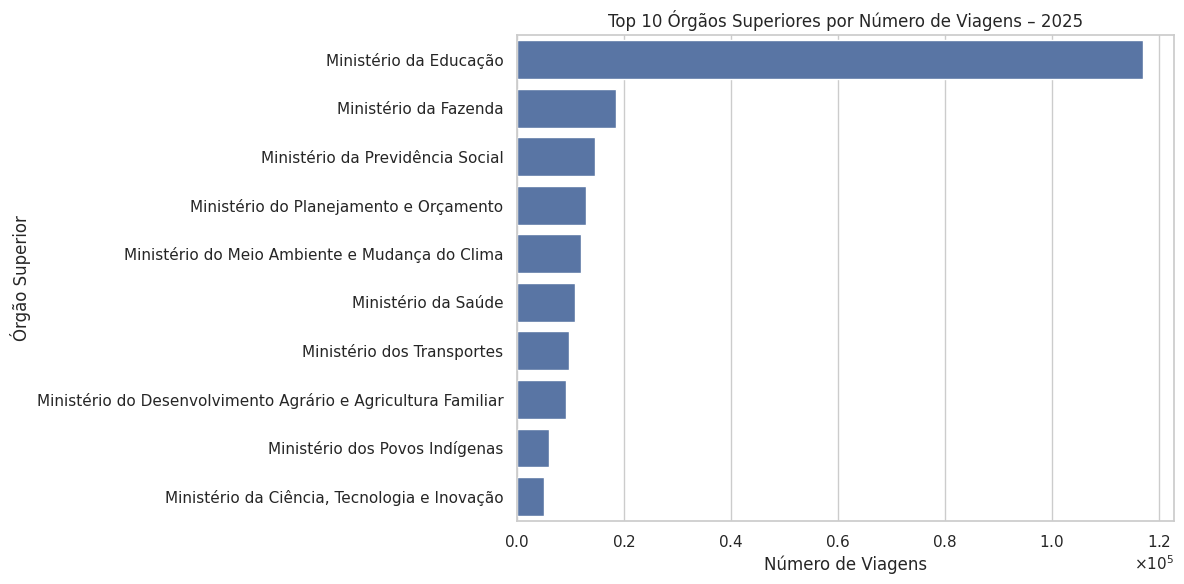

In [43]:
viagens_por_orgao = (
    df['nom_org_sup']
    .value_counts()
    .reset_index()
)

viagens_por_orgao.columns = ['Órgão Superior', 'Número de Viagens']

top_10 = viagens_por_orgao.head(10)

ax = sns.barplot(
    data=top_10,
    y='Órgão Superior',
    x='Número de Viagens'
)

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
ax.xaxis.set_major_formatter(formatter)

plt.title('Top 10 Órgãos Superiores por Número de Viagens – 2025')
plt.xlabel('Número de Viagens')
plt.ylabel('Órgão Superior')
plt.tight_layout()
plt.show()


A análise do volume de viagens por órgão superior mostra que o **Ministério da Educação (MEC)** lidera em número de deslocamentos, seguido pelo **Ministério da Fazenda** e pelo **Ministério da Previdência Social**.  
Esse comportamento é justificado por: Ampla estrutura descentralizada do Ministério da Educação, que engloba universidades federais, institutos federais e autarquias distribuídas nacionalmente; Atuação estratégica do Ministério da Fazenda em áreas como arrecadação, fiscalização e gestão econômica; Papel central da Previdência Social na administração de benefícios em todo o território nacional.  
Com a filtragem aplicada na Silver, foram excluídos registros de órgãos com vínculos indefinidos ou classificações inconsistentes, o que permitiu destacar com maior precisão os órgãos com maior impacto operacional real.

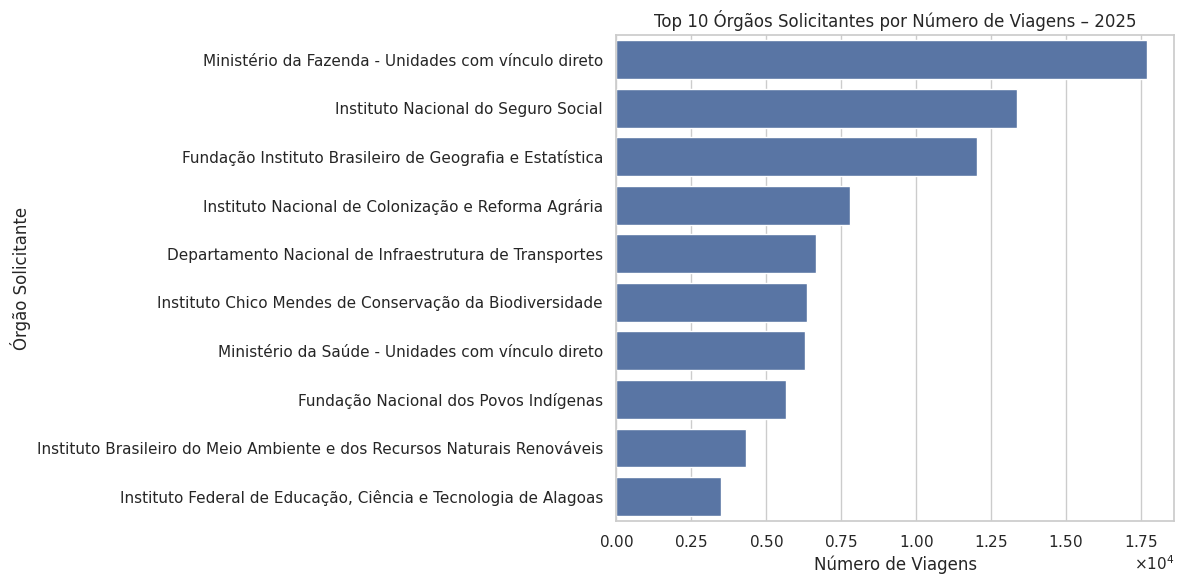

In [44]:
viagens_por_orgao_sol = (
    df['nom_org_sol']
    .value_counts()
    .reset_index()
)

viagens_por_orgao_sol.columns = ['Órgão Solicitante', 'Número de Viagens']

top_10 = viagens_por_orgao_sol.head(10)

ax = sns.barplot(
    data=top_10,
    y='Órgão Solicitante',
    x='Número de Viagens'
)

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
ax.xaxis.set_major_formatter(formatter)

plt.title('Top 10 Órgãos Solicitantes por Número de Viagens – 2025')
plt.xlabel('Número de Viagens')
plt.ylabel('Órgão Solicitante')
plt.tight_layout()
plt.show()


No recorte por órgão solicitante, observa-se que o **Ministério da Fazenda – Unidades com vínculo direto** apresenta o maior volume de viagens, seguido pelo **Instituto Nacional do Seguro Social (INSS)** e pela **Fundação Instituto Brasileiro de Geografia e Estatística (FIBGE)**.  
Esses resultados refletem:Atuação direta do Ministério da Fazenda por meio de unidades vinculadas a atividades fiscais, tributárias e administrativas; Necessidade recorrente de deslocamentos do INSS para atendimento, auditoria e gestão de suas unidades descentralizadas;
Caráter técnico e de campo da FIBGE, cujas atividades envolvem levantamentos, pesquisas e coleta de dados em escala nacional.  
A camada Silver removeu registros com vínculos organizacionais ambíguos, garantindo que apenas órgãos corretamente identificados fossem considerados na análise.

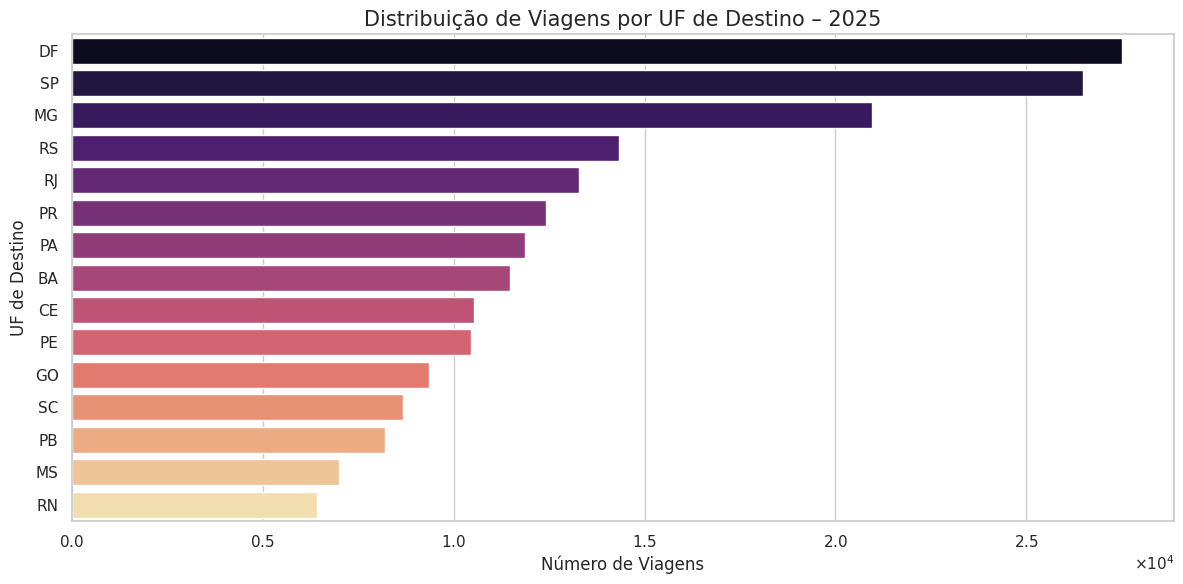

In [45]:
df['UF'] = df['destinos'].str[-2:]

viagens_por_uf = (
    df['UF']
    .value_counts()
    .head(15)
    .reset_index()
)

viagens_por_uf.columns = ['UF', 'Quantidade']

ax = sns.barplot(
    data=viagens_por_uf,
    x='Quantidade',
    y='UF',
    hue='UF',
    palette='magma',
    legend=False
)

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
ax.xaxis.set_major_formatter(formatter)

plt.title('Distribuição de Viagens por UF de Destino – 2025', fontsize=15)
plt.xlabel('Número de Viagens', fontsize=12)
plt.ylabel('UF de Destino', fontsize=12)
plt.tight_layout()
plt.show()


A distribuição das viagens por UF de destino aponta que **Distrito Federal (DF)**, **São Paulo (SP)** e **Minas Gerais (MG)** concentram o maior volume de deslocamentos.
- O Distrito Federal como centro administrativo e decisório do governo federal;
- São Paulo como principal polo econômico e institucional do país;
- Minas Gerais pela sua grande extensão territorial, densidade administrativa e número expressivo de unidades federais.  
A filtragem da camada Silver eliminou registros de destino inconsistentes ou mal formatados, tornando a extração da UF mais precisa e reforçando a confiabilidade dessa distribuição geográfica.

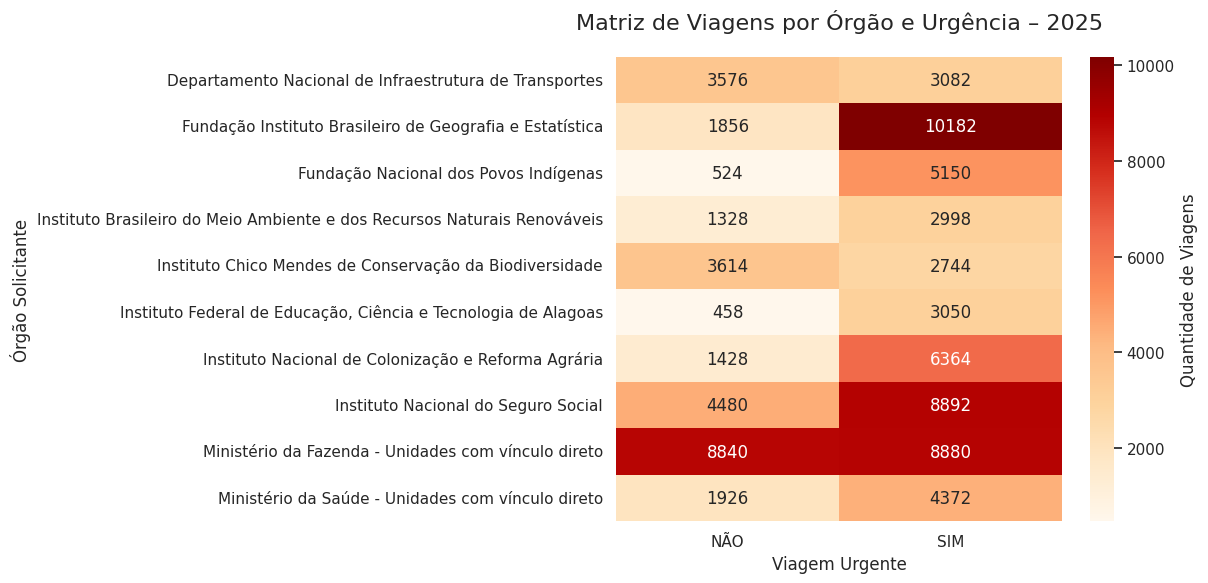

In [46]:
top_orgaos = df['nom_org_sol'].value_counts().nlargest(10).index

df_heat = df[df['nom_org_sol'].isin(top_orgaos)]

matriz_urgencia = (
    df_heat
    .groupby(['nom_org_sol', 'via_urg'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    matriz_urgencia,
    annot=True,
    fmt='d',
    cmap='OrRd',
    cbar_kws={'label': 'Quantidade de Viagens'}
)

plt.title('Matriz de Viagens por Órgão e Urgência – 2025', fontsize=16, pad=20)
plt.xlabel('Viagem Urgente', fontsize=12)
plt.ylabel('Órgão Solicitante', fontsize=12)
plt.tight_layout()
plt.show()


A análise cruzada entre órgão solicitante e urgência das viagens evidencia padrões operacionais distintos: A **FIBGE** apresenta predominância de viagens urgentes, o que pode ser associado à execução de pesquisas de campo com prazos rígidos e dependência de cronogramas externos; O **INSS** também concentra grande volume de viagens urgentes, refletindo demandas emergenciais ligadas à gestão de benefícios, auditorias e suporte operacional; O **Ministério da Fazenda** Unidades com vínculo direto apresenta maior volume de viagens sem caráter urgente, indicando deslocamentos mais previsíveis e planejados, como ações fiscais programadas e atividades administrativas recorrentes.  
Esses padrões tornam-se mais evidentes após a filtragem aplicada na Silver, que removeu registros com classificação de urgência inconsistente ou ausente, permitindo uma leitura mais fiel da dinâmica operacional de cada órgão.

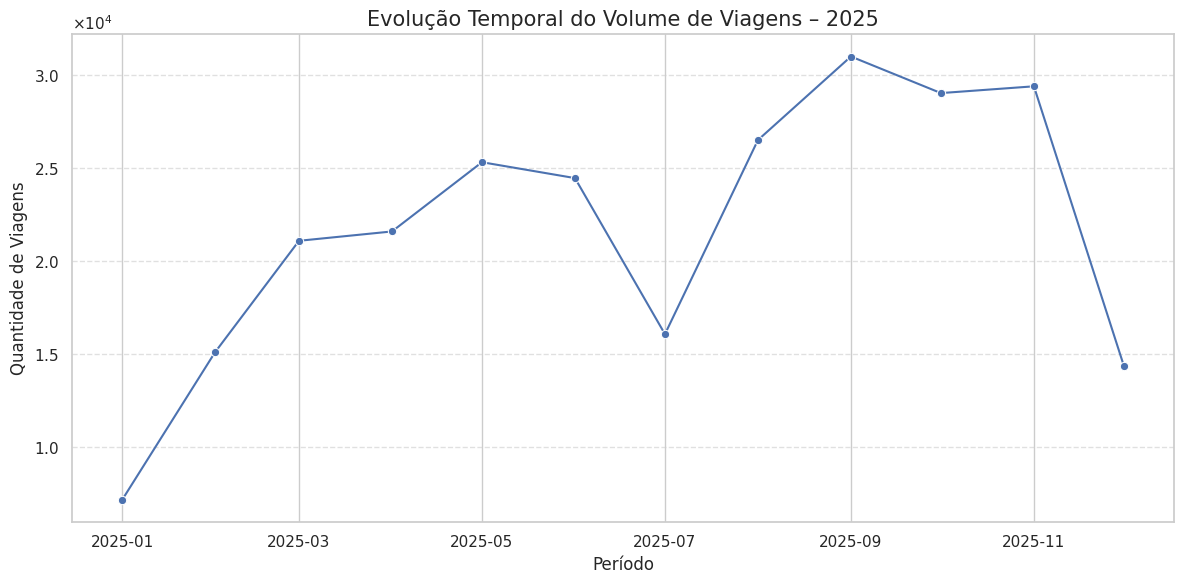

In [47]:
df['dat_ini'] = pd.to_datetime(
    df['dat_ini'],
    errors='coerce'
)

viagens_por_mes = (
    df
    .dropna(subset=['dat_ini'])
    .groupby(df['dat_ini'].dt.to_period('M'))
    .size()
    .reset_index(name='Quantidade')
)

viagens_por_mes['dat_ini'] = (
    viagens_por_mes['dat_ini']
    .dt.to_timestamp()
)

ax = sns.lineplot(
    data=viagens_por_mes,
    x='dat_ini',
    y='Quantidade',
    marker='o'
)

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
ax.yaxis.set_major_formatter(formatter)

plt.title('Evolução Temporal do Volume de Viagens – 2025', fontsize=15)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Quantidade de Viagens', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


A análise da evolução mensal do volume de viagens ao longo do ano evidencia picos significativos nos meses de setembro, outubro e novembro, enquanto janeiro e dezembro apresentam os menores volumes de deslocamentos.  
Esse comportamento pode ser explicado por fatores institucionais e operacionais:
- **Janeiro** concentra períodos de recesso administrativo, férias e menor ritmo de execução orçamentária.
- **Dezembro** sofre impacto direto do encerramento do exercício fiscal e da redução de atividades presenciais.
- **Setembro**, **outubro** e **novembro** representam meses de maior intensidade operacional, com execução de projetos, auditorias, fiscalizações e fechamento de metas institucionais.  
A filtragem aplicada na camada Silver, incluindo a remoção de registros com datas inválidas ou incompletas, garantiu que essa análise temporal fosse construída exclusivamente a partir de períodos corretamente identificados, eliminando distorções observadas na camada Raw.

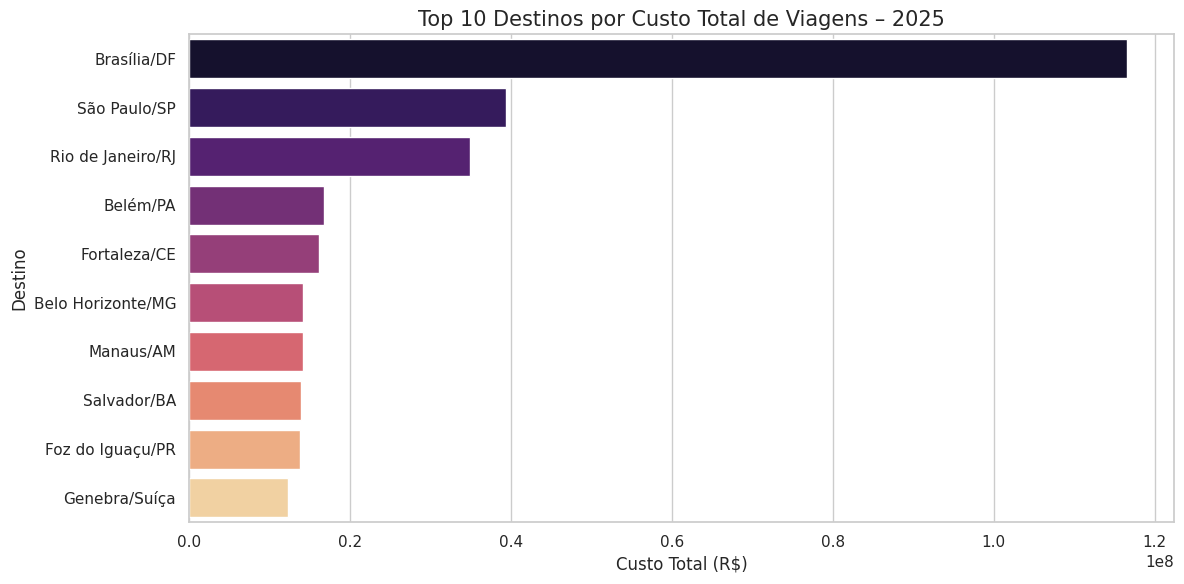

In [48]:
df['Valor_Total_Viagem'] = (
    df['val_dia'].fillna(0) +
    df['val_pas'].fillna(0) +
    df['val_out_gas'].fillna(0)
)

top_custo_destino = (
    df
    .groupby('destinos', as_index=False)['Valor_Total_Viagem']
    .sum()
    .sort_values('Valor_Total_Viagem', ascending=False)
    .head(10)
)

ax = sns.barplot(
    data=top_custo_destino,
    x='Valor_Total_Viagem',
    y='destinos',
    hue='destinos',
    palette='magma',
    legend=False
)

plt.title(
    'Top 10 Destinos por Custo Total de Viagens – 2025',
    fontsize=15
)
plt.xlabel('Custo Total (R$)', fontsize=12)
plt.ylabel('Destino', fontsize=12)
plt.tight_layout()
plt.show()


Ao analisar o custo total agregado por destino, observa-se que **Brasília**, **São Paulo** e **Rio de Janeiro** concentram os maiores volumes financeiros relacionados às viagens.  
Esse resultado está alinhado com os achados do Gráfico 1, porém sob a perspectiva de impacto financeiro, sendo justificado por:
- Brasília como principal destino administrativo, concentrando reuniões, capacitações e decisões estratégicas
- São Paulo e Rio de Janeiro como grandes centros econômicos, institucionais e logísticos
Maior frequência de deslocamentos associada a custos elevados de diárias, passagens e serviços
Na camada Silver, registros com valores inconsistentes, negativos ou incompletos foram removidos, e os campos financeiros foram padronizados, assegurando que os totais apresentados reflitam valores reais e confiáveis.

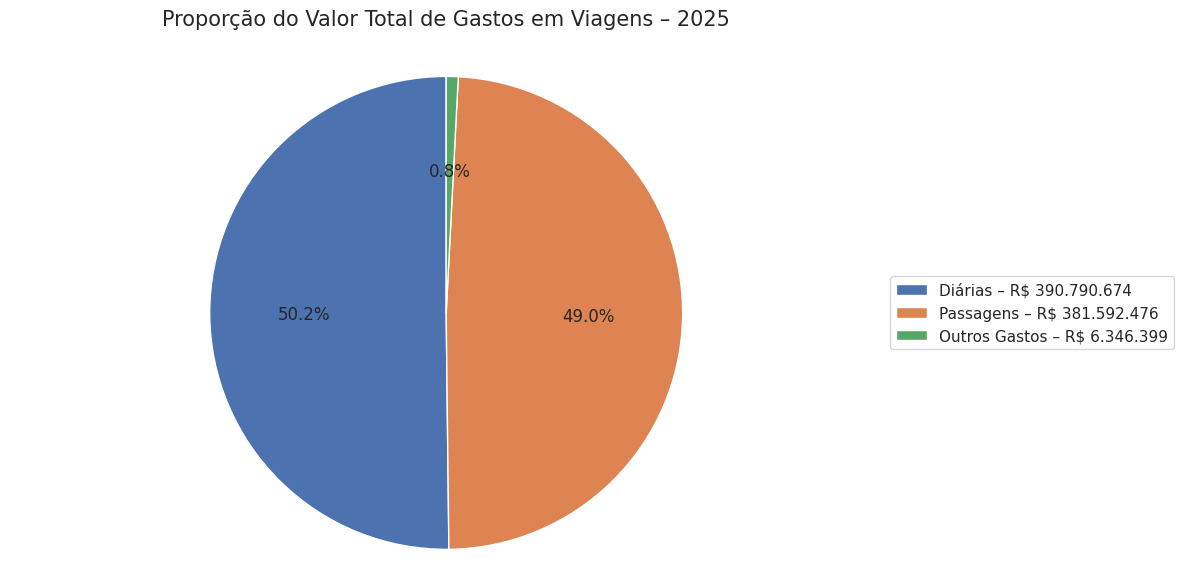

In [49]:
total_diarias = df['val_dia'].sum()
total_passagens = df['val_pas'].sum()
total_outros = df['val_out_gas'].sum()

labels = ['Diárias', 'Passagens', 'Outros Gastos']
valores = [total_diarias, total_passagens, total_outros]

def formatar_reais(valor):
    return f'R$ {valor:,.0f}'.replace(',', '.')

legendas = [
    f'Diárias – {formatar_reais(total_diarias)}',
    f'Passagens – {formatar_reais(total_passagens)}',
    f'Outros Gastos – {formatar_reais(total_outros)}'
]

plt.figure()

plt.pie(
    valores,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)

plt.legend(
    legendas,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    fontsize=11
)

plt.title(
    'Proporção do Valor Total de Gastos em Viagens – 2025',
    fontsize=15,
    pad=20
)

plt.axis('equal')
plt.tight_layout()
plt.show()


A composição dos gastos totais com viagens demonstra que:  
- **Diárias** representam a maior parcela do custo, correspondendo a 50,2% do valor total
- **Passagens** aparecem em seguida, com aproximadamente 49%
- **Outros gastos** possuem participação residual no total
Esse equilíbrio entre diárias e passagens indica que os custos estão fortemente relacionados tanto à permanência dos servidores nos destinos quanto ao deslocamento em si.  
A camada Silver foi fundamental para essa análise, pois:
- Eliminou registros com valores nulos ou não monetários
- Consolidou corretamente os campos financeiros
- Garantiu que a soma dos gastos refletisse apenas viagens válidas e completas